In [123]:
import os
import numpy as np
import woe.feature_process as fp
import woe.GridSearch as gs

import pandas as pd

from mlencoders.weight_of_evidence_encoder import WeightOfEvidenceEncoder


from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

import xgboost as xgb
from rgf.sklearn import RGFClassifier

In [108]:
df_train = pd.read_csv("../data/sparse/train_good.csv")
df_test = pd.read_csv("../data/sparse/test_good.csv")
df_labels = pd.read_csv("../data/labels_train.csv" , header = None )[1]
test_ids = pd.read_csv("../data/ids_test.csv" , header = None)[1].values
test_ids
df_train.shape

(307511, 269)

In [109]:
cat_cols = df_train.columns[:43]

cats_train = df_train[cat_cols]
cats_test = df_test[cat_cols]

cats_train.columns = [ "f_{}".format(i ) for i in range (  cats_train.shape[1]  )  ]
cats_test.columns = [ "f_{}".format(i ) for i in range (  cats_train.shape[1]   )  ]

In [110]:
cat_cols = list( cats_train.columns )

In [111]:
cats_train.head()

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_33,f_34,f_35,f_36,f_37,f_38,f_39,f_40,f_41,f_42
0,7,1,9,7,3,0,6,1,1,3,...,4,8,16,2,1,0,1,0,1,1
1,4,1,4,2,3,0,1,0,0,1,...,1,8,12,2,1,0,1,0,1,1
2,7,0,9,7,0,1,1,1,1,3,...,1,7,15,2,1,1,1,0,1,1
3,7,0,9,7,0,0,6,0,1,0,...,4,6,1,3,0,0,1,0,1,1
4,7,0,4,7,0,0,4,1,1,3,...,1,1,9,1,0,0,1,0,1,1


In [112]:
cats_test.head()

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_33,f_34,f_35,f_36,f_37,f_38,f_39,f_40,f_41,f_42
0,7,1,0,7,0,0,5,0,1,1,...,1,5,14,2,0,0,1,1,1,1
1,7,0,10,7,0,0,0,1,1,1,...,1,5,14,2,0,0,1,0,1,1
2,7,0,5,0,0,1,1,1,1,1,...,1,8,14,2,0,0,1,0,1,1
3,7,1,15,7,3,0,6,0,1,1,...,1,5,11,2,1,0,1,0,1,1
4,7,0,0,7,0,1,0,1,0,1,...,4,5,14,2,0,1,1,0,1,1


In [98]:
cats_train.shape

(307511, 43)

In [99]:
len( cat_cols)

43

In [113]:
enc = WeightOfEvidenceEncoder(cols= cat_cols )

x_train_enc = enc.fit_transform( cats_train , df_labels )
x_train_enc.head()

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_33,f_34,f_35,f_36,f_37,f_38,f_39,f_40,f_41,f_42
0,0.188675,-0.159608,0.297977,0.014753,-0.157558,0.056242,0.011729,0.250931,-0.015093,0.213706,...,0.125786,-0.117794,-0.100465,-0.056391,-0.148737,-0.053434,0.07661,0.001582,0.000059,0.000004
1,-0.363350,-0.159608,-0.266393,-0.080601,-0.157558,0.056242,-0.043314,-0.154307,0.033490,-0.071222,...,-0.039984,-0.117794,-0.322493,-0.056391,-0.148737,-0.053434,0.07661,0.001582,0.000059,0.000004
2,0.188675,0.150280,0.297977,0.014753,0.071397,-0.117353,-0.043314,0.250931,-0.015093,0.213706,...,-0.039984,-0.052128,-0.073842,-0.056391,-0.148737,0.193464,0.07661,0.001582,0.000059,0.000004
3,0.188675,0.150280,0.297977,0.014753,0.071397,0.056242,0.011729,-0.154307,-0.015093,0.229088,...,0.125786,0.056693,0.327418,0.225935,0.053430,-0.053434,0.07661,0.001582,0.000059,0.000004
4,0.188675,0.150280,-0.266393,0.014753,0.071397,0.056242,0.003683,0.250931,-0.015093,0.213706,...,-0.039984,0.435220,-0.095607,0.068888,0.053430,-0.053434,0.07661,0.001582,0.000059,0.000004


In [114]:
x_test_enc = enc.transform( cats_test )
x_test_enc.head()

/usr/local/lib/python2.7/dist-packages/mlencoders/base_encoder.py:44: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  X_encoded[col] = mapping['value'].loc[X_encoded[col].fillna(NAN_CATEGORY)].values


,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_33,f_34,f_35,f_36,f_37,f_38,f_39,f_40,f_41,f_42
0,0.188675,-0.159608,-0.231527,0.014753,0.071397,0.056242,0.036835,-0.154307,-0.015093,-0.071222,...,-0.039984,0.006042,0.127565,-0.056391,0.053430,-0.053434,0.07661,-0.026618,0.000059,0.000004
1,0.188675,0.150280,0.857622,0.014753,0.071397,0.056242,0.009936,0.250931,-0.015093,-0.071222,...,-0.039984,0.006042,0.127565,-0.056391,0.053430,-0.053434,0.07661,0.001582,0.000059,0.000004
2,0.188675,0.150280,0.374633,-0.427263,0.071397,-0.117353,-0.043314,0.250931,-0.015093,-0.071222,...,-0.039984,-0.117794,0.127565,-0.056391,0.053430,-0.053434,0.07661,0.001582,0.000059,0.000004
3,0.188675,-0.159608,0.193663,0.014753,-0.157558,0.056242,0.011729,-0.154307,-0.015093,-0.071222,...,-0.039984,0.006042,-0.217053,-0.056391,-0.148737,-0.053434,0.07661,0.001582,0.000059,0.000004
4,0.188675,0.150280,-0.231527,0.014753,0.071397,-0.117353,0.009936,0.250931,0.033490,-0.071222,...,0.125786,0.006042,0.127565,-0.056391,0.053430,0.193464,0.07661,0.001582,0.000059,0.000004


In [116]:

df_train.loc[: ,   df_train.columns[:43]] = x_train_enc.values
df_train.head()

,NAME_INCOME_TYPE,EMERGENCYSTATE_MODE,OCCUPATION_TYPE,NAME_TYPE_SUITE,FONDKAPREMONT_MODE,FLAG_OWN_CAR,WEEKDAY_APPR_PROCESS_START,CODE_GENDER,FLAG_OWN_REALTY,NAME_FAMILY_STATUS,...,MEAN(card.CNT_DRAWINGS_POS_CURRENT),MEAN(prev.CNT_PAYMENT),MAX(card.AMT_RECIVABLE),LAST(prev.AMT_CREDIT),LAST(card.AMT_PAYMENT_CURRENT),MEAN(prev.DAYS_LAST_DUE_1ST_VERSION),MAX(card.CNT_DRAWINGS_OTHER_CURRENT),MEAN(bureau.AMT_CREDIT_SUM_DEBT),LAST(card.AMT_PAYMENT_TOTAL_CURRENT),MAX(prev.RATE_INTEREST_PRIVILEGED)
0,0.188675,-0.159608,0.297977,0.014753,-0.157558,0.056242,0.011729,0.250931,-0.015093,0.213706,...,0.0,24.000000,0.0,179055.0,0.0,125.000000,0.0,49156.2,0.0,0.0
1,-0.363350,-0.159608,-0.266393,-0.080601,-0.157558,0.056242,-0.043314,-0.154307,0.033490,-0.071222,...,0.0,10.000000,0.0,348637.5,0.0,-1004.333333,0.0,0.0,0.0,0.0
2,0.188675,0.150280,0.297977,0.014753,0.071397,-0.117353,-0.043314,0.250931,-0.015093,0.213706,...,0.0,4.000000,0.0,20106.0,0.0,-694.000000,0.0,0.0,0.0,0.0
3,0.188675,0.150280,0.297977,0.014753,0.071397,0.056242,0.011729,-0.154307,-0.015093,0.229088,...,0.0,23.000000,0.0,0.0,0.0,91584.000000,0.0,0.0,0.0,0.0
4,0.188675,0.150280,-0.266393,0.014753,0.071397,0.056242,0.003683,0.250931,-0.015093,0.213706,...,0.0,20.666667,0.0,284400.0,0.0,-837.200000,0.0,0.0,0.0,0.0


In [103]:
x_test_enc.shape

(48744, 43)

In [104]:
df_test.shape

(48744, 269)

In [117]:
df_test.loc[: , df_test.columns[:43] ] = x_test_enc.values

In [118]:
x_test_enc.head()

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_33,f_34,f_35,f_36,f_37,f_38,f_39,f_40,f_41,f_42
0,0.188675,-0.159608,-0.231527,0.014753,0.071397,0.056242,0.036835,-0.154307,-0.015093,-0.071222,...,-0.039984,0.006042,0.127565,-0.056391,0.053430,-0.053434,0.07661,-0.026618,0.000059,0.000004
1,0.188675,0.150280,0.857622,0.014753,0.071397,0.056242,0.009936,0.250931,-0.015093,-0.071222,...,-0.039984,0.006042,0.127565,-0.056391,0.053430,-0.053434,0.07661,0.001582,0.000059,0.000004
2,0.188675,0.150280,0.374633,-0.427263,0.071397,-0.117353,-0.043314,0.250931,-0.015093,-0.071222,...,-0.039984,-0.117794,0.127565,-0.056391,0.053430,-0.053434,0.07661,0.001582,0.000059,0.000004
3,0.188675,-0.159608,0.193663,0.014753,-0.157558,0.056242,0.011729,-0.154307,-0.015093,-0.071222,...,-0.039984,0.006042,-0.217053,-0.056391,-0.148737,-0.053434,0.07661,0.001582,0.000059,0.000004
4,0.188675,0.150280,-0.231527,0.014753,0.071397,-0.117353,0.009936,0.250931,0.033490,-0.071222,...,0.125786,0.006042,0.127565,-0.056391,0.053430,0.193464,0.07661,0.001582,0.000059,0.000004


In [119]:
df_test.to_csv( "../data/test_woe.csv" , index = False )
df_train.to_csv("../data/train_woe.csv" , index = False )

In [122]:

x_train_enc.head()

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_33,f_34,f_35,f_36,f_37,f_38,f_39,f_40,f_41,f_42
0,0.188675,-0.159608,0.297977,0.014753,-0.157558,0.056242,0.011729,0.250931,-0.015093,0.213706,...,0.125786,-0.117794,-0.100465,-0.056391,-0.148737,-0.053434,0.07661,0.001582,0.000059,0.000004
1,-0.363350,-0.159608,-0.266393,-0.080601,-0.157558,0.056242,-0.043314,-0.154307,0.033490,-0.071222,...,-0.039984,-0.117794,-0.322493,-0.056391,-0.148737,-0.053434,0.07661,0.001582,0.000059,0.000004
2,0.188675,0.150280,0.297977,0.014753,0.071397,-0.117353,-0.043314,0.250931,-0.015093,0.213706,...,-0.039984,-0.052128,-0.073842,-0.056391,-0.148737,0.193464,0.07661,0.001582,0.000059,0.000004
3,0.188675,0.150280,0.297977,0.014753,0.071397,0.056242,0.011729,-0.154307,-0.015093,0.229088,...,0.125786,0.056693,0.327418,0.225935,0.053430,-0.053434,0.07661,0.001582,0.000059,0.000004
4,0.188675,0.150280,-0.266393,0.014753,0.071397,0.056242,0.003683,0.250931,-0.015093,0.213706,...,-0.039984,0.435220,-0.095607,0.068888,0.053430,-0.053434,0.07661,0.001582,0.000059,0.000004


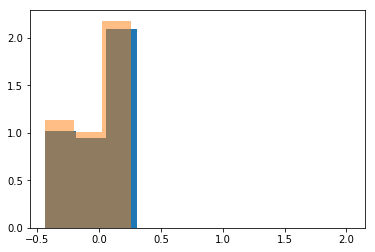

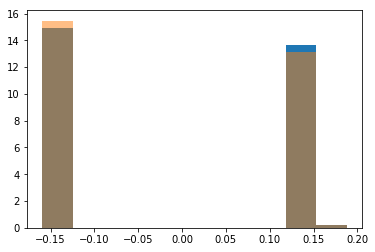

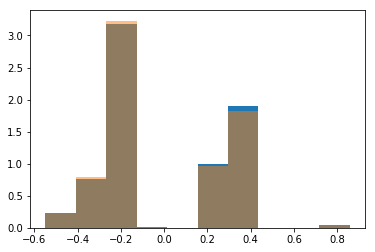

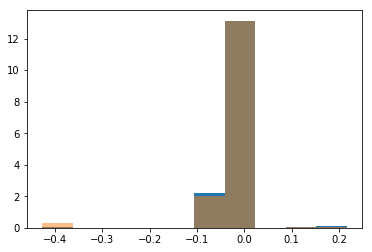

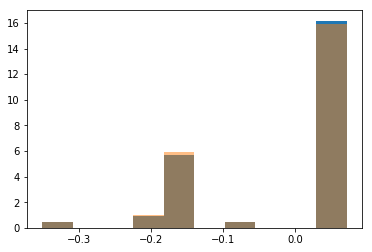

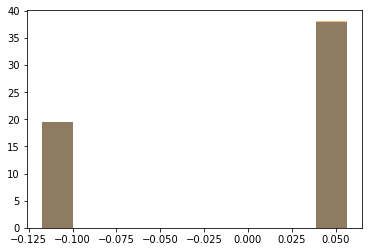

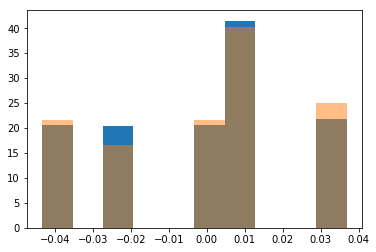

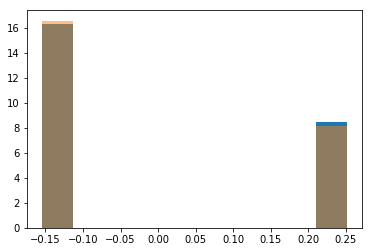

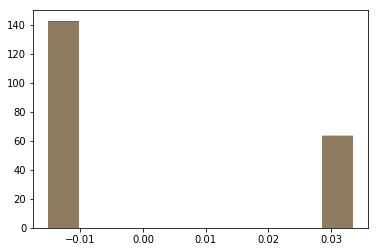

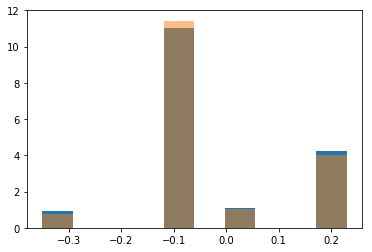

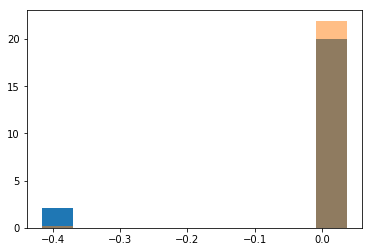

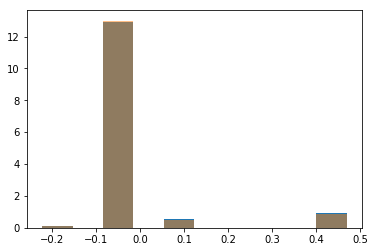

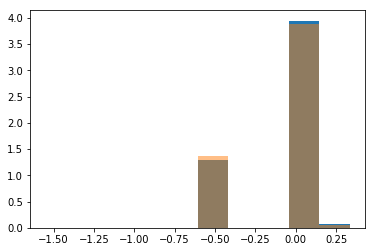

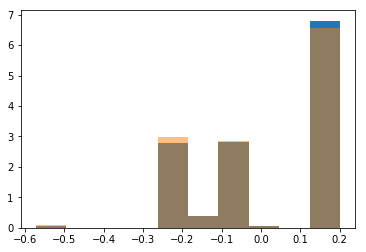

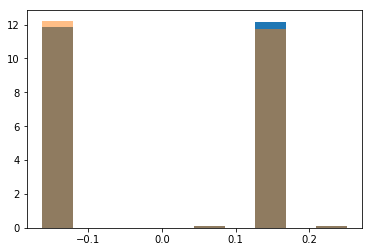

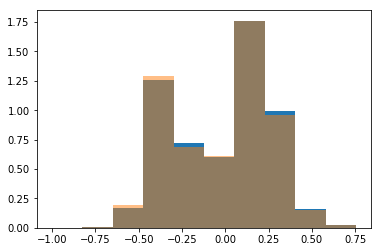

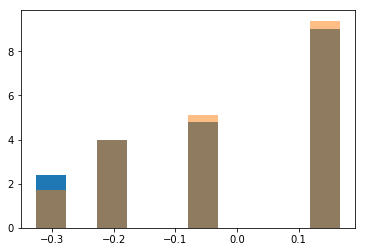

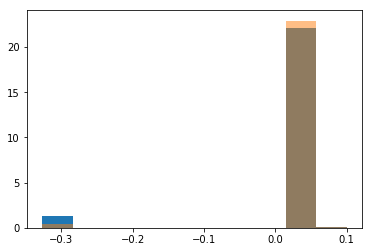

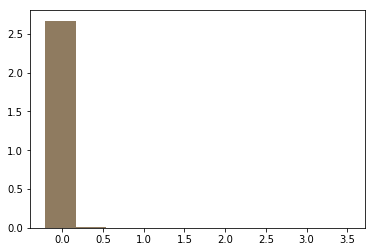

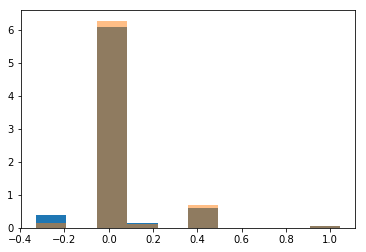

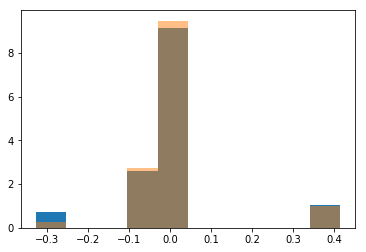

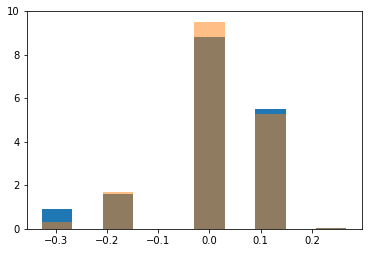

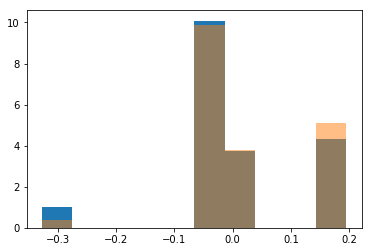

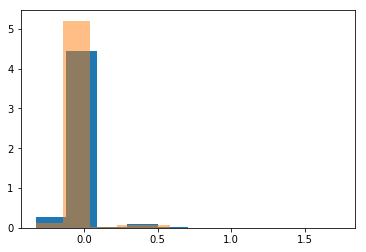

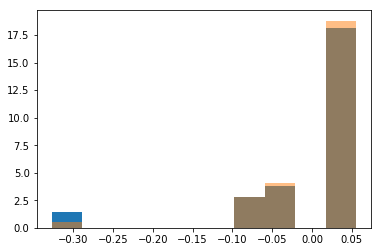

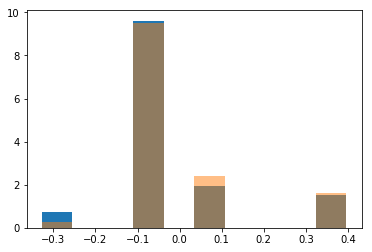

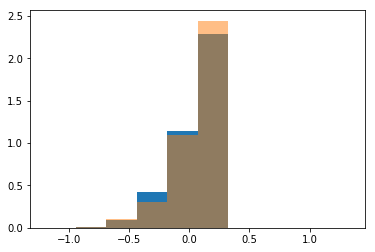

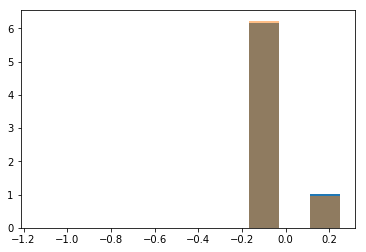

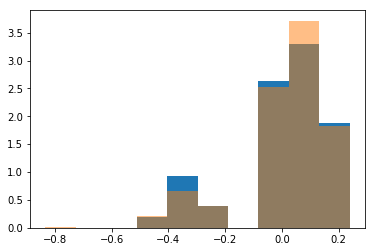

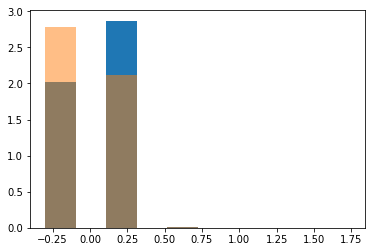

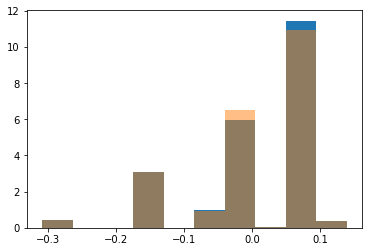

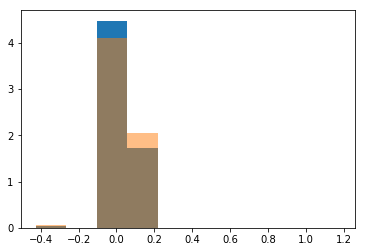

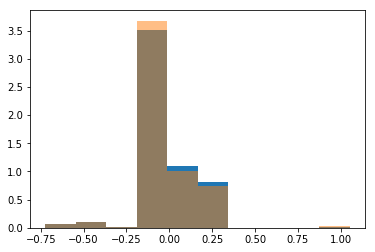

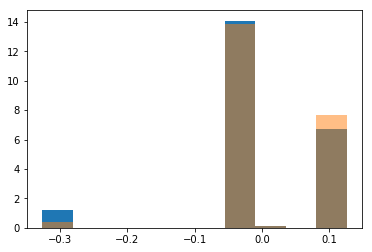

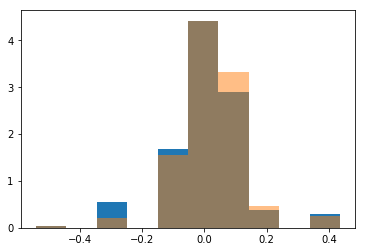

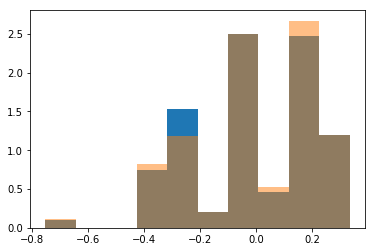

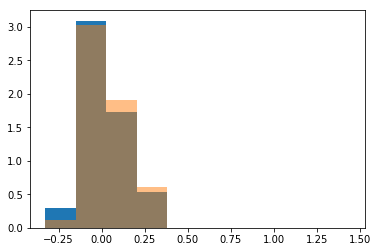

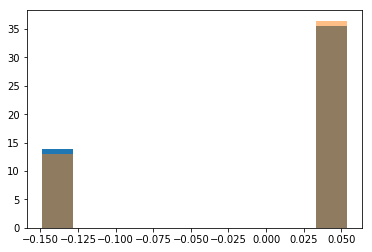

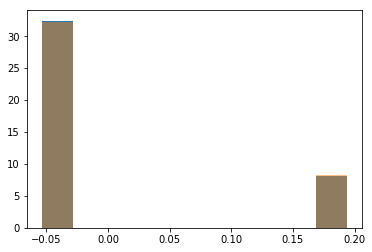

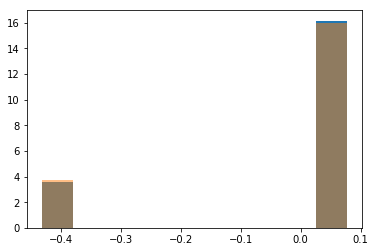

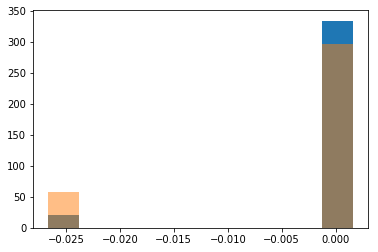

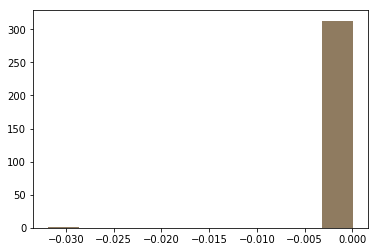

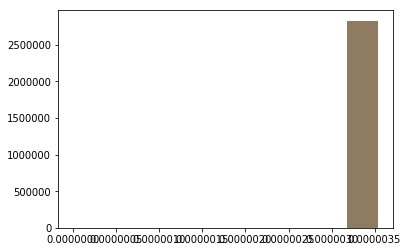

In [144]:
import matplotlib.pyplot as plt

for col in x_train_enc.columns:
    plt.hist( x_train_enc[col]  , density = True )
    plt.hist( x_test_enc[col] , density = True , alpha = 0.5 )
    plt.show()

# Train on woed

In [141]:
learning_rate = 0.1
num_leaves = 16
min_data_in_leaf = 2000
feature_fraction = 0.9
num_boost_round = 10000
params = {"objective": "binary",
          "boosting_type": "dart",
          "learning_rate": learning_rate,
          "metric":["auc" ,"binary_logloss"] , 
          "num_leaves": num_leaves,
           "max_bin": 256,
          "feature_fraction": feature_fraction,
          "verbosity": 1,
          "drop_rate": 0.01,
          "is_unbalance": False,
          "max_drop": 50,
          "min_child_samples": 20,
          "min_child_weight": 150,
          "min_split_gain": 0.5,
          "max_depth": -1, 
          "reg_alpha" : 20 , 
          "reg_lambda": 20 , 
          "min_gain_to_split" : 0.5 ,
          "bagging_freq" : 1 , 
          "subsample" : 0.9 , 
          "device_type": "gpu"
}

In [142]:
final_cv_train = np.zeros(len(df_labels))
final_cv_pred = np.zeros(len( test_ids ))

new_train = x_train_enc.values
labels_train = df_labels.values
NFOLDS = 5 

M = 16 
x_score = []
for s in range( M ):
    
    params['seed'] = s
    
    cv_train = np.zeros( len( df_labels ))
    cv_pred = np.zeros( len( test_ids ) )
    kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=s)
    kf  = kfold.split(  x_train_enc , df_labels )
    
    for i, (train_fold, validate) in enumerate(kf):
        
        X_train, X_validate, label_train, label_validate = new_train[train_fold, :], new_train[validate, :], labels_train[train_fold], labels_train[validate]
    
    #X_train, X_validate, label_train, label_validate = X[train_fold, :], X[validate, :], labels_train[train_fold], labels_train[validate]
        dtrain = lgb.Dataset( X_train , label_train  )
    
        dvalid = lgb.Dataset(  X_validate  , label_validate , reference=dtrain )
        bst = lgb.train(params, dtrain , num_boost_round , valid_sets=[dvalid ] , verbose_eval = 100 , early_stopping_rounds = 100 )
    #best_trees.append(bst.best_iteration)    
        cv_pred +=  bst.predict(  x_enc_test , num_iteration = bst.best_iteration )
    #cv_eval_total += bst.predict( x_val , num_iteration = bst.best_iteration )          
        cv_train[validate] += bst.predict( X_validate )
        
        
    cv_pred /= NFOLDS
    
    final_cv_train += cv_train
    final_cv_pred += cv_pred
    
    print("cv score - on train:")
    print( roc_auc_score(labels_train, cv_train))
    print( "current score in fold:", roc_auc_score( labels_train , final_cv_train / (s + 1.)), s+1)
    
    x_score.append(roc_auc_score( labels_train , cv_train))

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.268262	valid_0's auc: 0.666349
[200]	valid_0's binary_logloss: 0.267754	valid_0's auc: 0.667424
[300]	valid_0's binary_logloss: 0.267646	valid_0's auc: 0.668115
Early stopping, best iteration is:
[256]	valid_0's binary_logloss: 0.267504	valid_0's auc: 0.668082


NameError: name 'x_enc_test' is not defined